In [53]:
# import dask.distributed
# from matplotlib.colors import ListedColormap
# import pystac_client

# import cartopy.crs as ccrs
# import numpy as np
# import pandas as pd
# import planetary_computer
# import rasterio
# import rasterio.features
# import stackstac
# import geojson
# from pystac.extensions.projection import ProjectionExtension as proj



import dask.distributed
from matplotlib.colors import ListedColormap
import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import rasterio
import rasterio.features
import stackstac

In [54]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [55]:
bbox = [10.299683,50.149065,11.942139,50.977535]

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [10.299683, 50.149065],
            [11.942139, 50.149065],
            [11.942139, 50.977535],
            [10.299683, 50.977535],
            [10.299683, 50.149065],
        ]
    ],
}

# with open('region53.geojsonl.json') as src:
#     region_53_57 = geojson.load(src)

search = catalog.search(collections=["io-lulc"], intersects=area_of_interest)

items = search.item_collection()
print(f"Returned {len(items)} Items")


Returned 2 Items


In [56]:
# The STAC metadata contains some information we'll want to use when creating
# our merged dataset. Get the EPSG code of the first item and the nodata value.
item = items[0]
epsg = proj.ext(item).epsg
nodata = item.assets["data"].extra_fields["raster:bands"][0]["nodata"]
bounds_latlon = rasterio.features.bounds(area_of_interest)

# Create a single DataArray from out multiple resutls with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = stackstac.stack(
    items, epsg=epsg, dtype=np.ubyte, fill_value=nodata, bounds_latlon=bounds_latlon
)

stack

<xarray.DataArray 'stackstac-c25b340f56775a5224aa19982e760474' (time: 2,
                                                                band: 1,
                                                                y: 9818,
                                                                x: 12110)>
dask.array<fetch_raster_window, shape=(2, 1, 9818, 12110), dtype=uint8, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time               (time) datetime64[ns] 2020-06-01 2020-06-01
    id                 (time) <U8 '33U-2020' '32U-2020'
  * band               (band) <U4 'data'
  * x                  (x) float64 1.642e+05 1.643e+05 ... 2.853e+05 2.853e+05
  * y                  (y) float64 5.658e+06 5.658e+06 ... 5.56e+06 5.56e+06
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    ...                 ...
    label:type         <U6 'raster'
    proj:epsg          (time) int64 32633 32632
    io:tile_id         (time) <U3 '33U' '32U'
    label:description  <U4 'lulc'
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 32633
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(164250.0, 5559680.0, 285350.0...
    crs:         epsg:32633
    transform:   | 10.00, 0.00, 164250.00|\n| 0.00,-10.00, 5657860.00|\n| 0.0...
    resolution:  10.0

In [57]:


client = dask.distributed.Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")



/proxy/34563/status


/home/sc.uni-leipzig.de/my982hzao/.conda/envs/Forest_BareSoil_Env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34563 instead
  warnings.warn(


In [58]:


merged = stackstac.mosaic(stack, dim="time", axis=None, nodata=0).squeeze().compute()
merged



<xarray.DataArray 'stackstac-c25b340f56775a5224aa19982e760474' (y: 9818,
                                                                x: 12110)>
array([[2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)
Coordinates:
    band               <U4 'data'
  * x                  (x) float64 1.642e+05 1.643e+05 ... 2.853e+05 2.853e+05
  * y                  (y) float64 5.658e+06 5.658e+06 ... 5.56e+06 5.56e+06
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    end_datetime       <U20 '2021-01-01T00:00:00Z'
    start_datetime     <U20 '2020-01-01T00:00:00Z'
    label:properties   object None
    label:type         <U6 'raster'
    label:description  <U4 'lulc'
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 32633
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(164250.0, 5559680.0, 285350.0...
    crs:         epsg:32633
    transform:   | 10.00, 0.00, 164250.00|\n| 0.00,-10.00, 5657860.00|\n| 0.0...
    resolution:  10.0

In [59]:
merged.plot()
plt.show()

In [ ]:
class_names = merged.coords["label:classes"].item()["classes"]
class_count = len(class_names)

with rasterio.open(item.assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(class_count)
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

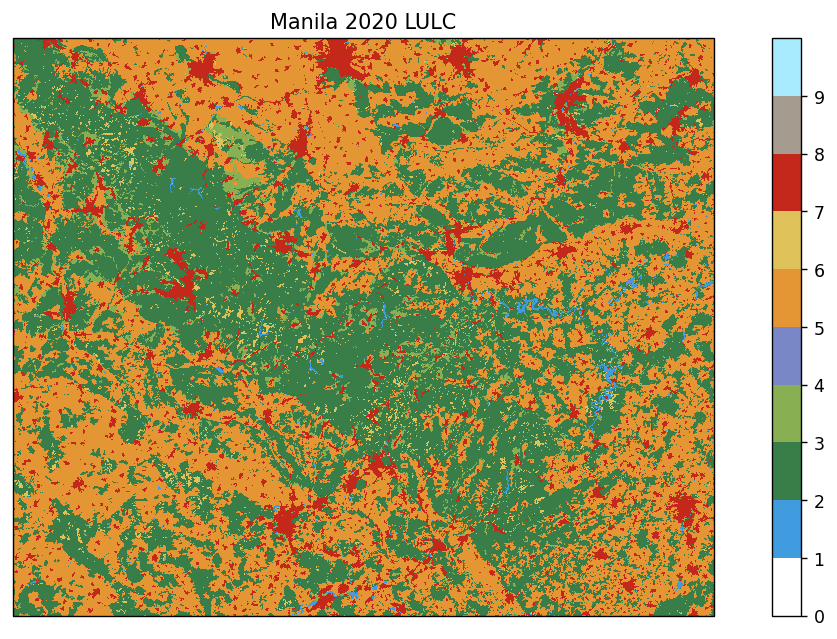

In [ ]:


fig, ax = plt.subplots(
    figsize=(12, 6), dpi=125, subplot_kw=dict(projection=ccrs.epsg(epsg)), frameon=False
)
p = merged.plot(
    ax=ax,
    transform=ccrs.epsg(epsg),
    cmap=cmap,
    add_colorbar=False,
    vmin=0,
    vmax=class_count,
)
ax.set_title("Manila 2020 LULC")

cbar = plt.colorbar(p)
cbar.set_ticks(range(class_count))
cbar.set_ticklabels(class_names)

